In [1]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, RMSEMeasurement
from trecs.components import Users

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from wrapper.models.bubble import BubbleBurster
from wrapper.metrics.evaluation_metrics import NoveltyMetric, DiversityMetric, TopicInteractionSpread
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from src.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools

In [2]:
preprocessing_config = {
    'num_attributes':20,
    'max_iter':1000,
    'num_clusters':15
}

In [3]:
data_path = '/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data'
binary_ratings_matrix = load_and_process_movielens(file_path=data_path)
user_representation, item_representation = compute_embeddings(binary_ratings_matrix, n_attrs=preprocessing_config["num_attributes"], max_iter=preprocessing_config["max_iter"])

item_cluster_ids, item_cluster_centers = compute_constrained_clusters(embeddings=item_representation.T, name='item_clusters', n_clusters=preprocessing_config["num_clusters"])
user_cluster_ids, user_cluster_centers = compute_constrained_clusters(embeddings=user_representation, name='user_clusters', n_clusters=preprocessing_config["num_clusters"])
global_user_pairs = create_global_user_pairs(user_cluster_ids)
# user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers)
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_cluster_ids)

In [ ]:
metric_to_y_label = {
    "mse":"mse",
    "mean_global_cosine_sim":"average cosine sim",
    "mean_intra_cluster_cosine_sim":"average cosine sim",
    "mean_inter_cluster_cosine_sim":"average cosine sim",
    "rmse":"rmse",
    "mean_novelty":"average item novelty",
    "mean_slate_topic_diversity":"average topic diversity across slates",
    "topic_interaction_spread":"topic interaction spread",
    "interaction_spread":"item interaction spread",
}

empty_y_labels = {key:"" for key in metric_to_y_label}

graphing_metrics = [
    "mse",
    "mean_global_cosine_sim",
    "mean_intra_cluster_cosine_sim",
    "mean_inter_cluster_cosine_sim",
    "rmse",
    "mean_novelty",
    "mean_slate_topic_diversity",
    "topic_interaction_spread",
    "NEW_mean_novelty",
]

In [ ]:
users = {
    'drift':0.1,
    'attention_exp':-0.8,
    'repeat_interactions':0,
}

model_config = {
    'num_attributes':preprocessing_config["num_attributes"],
    'num_items_per_iter': 10,
    'record_base_state': True,
}
        
train_between_steps = 1
train_config = {
    'timesteps':50 if train_between_steps==0 else 10,
}    
run_config = {
    'timesteps':50 if train_between_steps==0 else 90,
    'train_between_steps':train_between_steps, 
    'repeated_items':0, 
    'random_items_per_iter':0,
}

users = Users(
    actual_user_profiles=user_representation,
    **users_config
)

In [ ]:
metrics_list = [
    MSEMeasurement(),
    MeanCosineSim(pairs=global_user_pairs, name='mean_global_cosine_sim', diagnostics=True),
    MeanCosineSim(pairs=intra_cluster_user_pairs, name='mean_intra_cluster_cosine_sim', diagnostics=True),
    MeanCosineSim(pairs=inter_cluster_user_pairs, name='mean_inter_cluster_cosine_sim', diagnostics=True),
    RMSEMeasurement(),
    NoveltyMetric(),
    DiversityMetric(),
    InteractionSpread(),
    NoveltyMetric()
]

bubble = BubbleBurster(
    actual_user_representation=users, 
    actual_item_representation=item_representation,
    item_topics=item_cluster_ids,
    **model_config
)
bubble.add_metrics(*metrics_list)
bubble.startup_and_train(**train_config)
bubble.run(**run_config)
bubble.close() # end logging

measurements = xquad.get_measurements()

In [ ]:
from src.plotting import graph_metrics_by_axis

fig, axs = plt.subplots(3, 3, figsize=(10, 5))
for i in range(9):
    curr_ax = axs[int(i/3), i%3]
    graph_metrics_by_axis(curr_ax, measurements, graphing_metrics[i], empty_y_labels)
plt.suptitle(f"Bubble - {train_between_steps}retraining")
plt.tight_layout()

In [4]:

class TEST_xQuAD(BubbleBurster):
    """
    Attributes
    -----------
        Inherited from BubbleBurster: :class:`BubbleBurster`
        Inherited from ContentFiltering: :class:`~models.content.ContentFiltering`
        Inherited from BaseRecommender: :class:`~models.recommender.BaseRecommender`
    """
    # We define default values in the signature so we can call the constructor with no argument

    def __init__(self, xquad_method, alpha, **kwargs):
        super().__init__(**kwargs)
        self.xquad_method_str = xquad_method
        if xquad_method == "binary":
            self.xquad_method = self.compute_binary_xquad_scores
        elif xquad_method == "smooth":
            self.xquad_method = self.compute_smooth_xquad_scores
        else:
            raise Exception("Must supply valid method to compute xQuAD scores")
        self.alpha = alpha
        assert(self.probabilistic_recommendations == False), "Cannot use probabalistic_recommendations with the xQuAD model"
        
    def compute_binary_xquad_scores(self, filtered_scores, curr_rec_slate_items, curr_rec_slate_topics, item_topics, user_vec):
        if curr_rec_slate_items is not None:
            accuracy_term = filtered_scores
            diversity_term = curr_rec_slate_topics[user_vec[:,:], item_topics] >= 1
            return (1-self.alpha)*accuracy_term + self.alpha*(1 - diversity_term)
        else:
            xquad_scores = (1-self.alpha) * filtered_scores
            return xquad_scores
    
    def compute_smooth_xquad_scores(self, filtered_scores, curr_rec_slate_items, curr_rec_slate_topics, item_topics, user_vec):
        if curr_rec_slate_items is not None:
            accuracy_term = filtered_scores
            diversity_term = np.divide(curr_rec_slate_topics[user_vec[:,:], item_topics], np.sum(curr_rec_slate_topics, axis=1).reshape((-1,1)))
            return (1-self.alpha)*accuracy_term + self.alpha*(1 - diversity_term)
        else:
            xquad_scores = (1-self.alpha) * filtered_scores
            return xquad_scores
        
    def generate_recommendations(self, k=1, item_indices=None):
        """
       Implementation adapted from: 
            `Managing Popularity Bias in Recommender 
            Systems with Personalized Re-ranking`
       where item popularity (long-tail head v. short head) is applied to the `topics` construct
       studied in this research project.

        Parameters
        -----------

            k : int, default 1
                Number of items to recommend.

            item_indices : :obj:`numpy.ndarray`, optional
                A matrix containing the indices of the items each user has not yet
                interacted with. It is used to ensure that the user is presented
                with items they have not already interacted with. If `None`,
                then the user may be recommended items that they have already
                interacted with.

        Returns
        ---------
            Recommendations: :obj:`numpy.ndarray`
        """
        if item_indices is not None:
            if item_indices.size < self.num_users:
                raise ValueError(
                    "At least one user has interacted with all items!"
                    "To avoid this problem, you may want to allow repeated items."
                )
            if k > item_indices.shape[1]:
                raise ValueError(
                    f"There are not enough items left to recommend {k} items to each user."
                )
        if k == 0:
            return np.array([]).reshape((self.num_users, 0)).astype(int)
        
        s_filtered = mo.to_dense(self.predicted_scores.filter_by_index(item_indices))
        row = np.repeat(self.users.user_vector, item_indices.shape[1])
        row = row.reshape((self.num_users, -1))
        
        curr_rec_slate_topics = np.zeros((self.num_users, self.num_topics))
        item_topics = np.repeat(self.item_topics.reshape((1, -1)), self.num_users, axis=0)
        item_topics = item_topics[row[:, :], item_indices]
        curr_rec_slate = None
        for i in range(self.num_items_per_iter):
            if not np.array_equal(s_filtered < 0, np.isneginf(s_filtered)):
                raise Exception("There are negative predicted scores")
            xquad_scores = self.xquad_method(s_filtered, curr_rec_slate, curr_rec_slate_topics, item_topics, row)
            max_score_item = mo.top_k_indices(xquad_scores, 1, self.random_state)
            max_score_item_id = item_indices[self.users.user_vector, max_score_item.reshape(-1,)].reshape(-1,1)
            # Adding max scoring item to current rec slate
            if curr_rec_slate is not None:
                curr_rec_slate = np.hstack((curr_rec_slate, max_score_item.reshape(-1,1)))
            else:
                curr_rec_slate = max_score_item.reshape(-1,1)
            # Updating topic matrix for current rec slate
            max_item_topics = self.item_topics[max_score_item_id].reshape(-1,)
            curr_rec_slate_topics[self.users.user_vector, max_item_topics] += 1
            np.put_along_axis(s_filtered, max_score_item.reshape((-1,1)), float("-inf"), axis=1)
            
        assert(curr_rec_slate.shape[1] == self.num_items_per_iter), "Size of rec slate does not match num_items_per_iter"
        assert(np.all(np.sum(curr_rec_slate_topics, axis=1) == 10)), "Rec slate topic count does not equal num_items_per_iter"
        
        curr_rec_slate = item_indices[row[:, :k], curr_rec_slate]
        
        if self.is_verbose():
            self.log(f"Item indices:\n{str(item_indices)}")
            self.log(
                f"xQuAD recommendation slate, method={self.xquad_method_str}, alpha={self.alpha}:\n{str(curr_rec_slate)}"
            )
        return curr_rec_slate

In [28]:
metric_to_y_label = {
    "mse":"mse",
    "mean_global_cosine_sim":"average cosine sim",
    "mean_intra_cluster_cosine_sim":"average cosine sim",
    "mean_inter_cluster_cosine_sim":"average cosine sim",
    "rmse":"rmse",
    "mean_novelty":"average item novelty",
    "mean_slate_topic_diversity":"average topic diversity across slates",
    "topic_interaction_spread":"topic interaction spread",
    "interaction_spread":"item interaction spread",
}

empty_y_labels = {key:"" for key in metric_to_y_label}

graphing_metrics = [
    "mse",
    "mean_global_cosine_sim",
    "mean_intra_cluster_cosine_sim",
    "mean_inter_cluster_cosine_sim",
    "rmse",
    "mean_novelty",
    "mean_slate_topic_diversity",
    "topic_interaction_spread",
    "interaction_spread",
]

In [29]:
test_xquad_params = [('binary', 0.1), ('binary', 0.25), ('smooth', 0.1), ('smooth', 0.25)]

users = {
    'drift':0.1,
    'attention_exp':-0.8,
    'repeat_interactions':0,
}

model_config = {
    'num_attributes':preprocessing_config["num_attributes"],
    'num_items_per_iter': 10,
    'record_base_state': True,
}
        
train_between_steps = 1
train_config = {
    'timesteps':50 if train_between_steps==0 else 10,
}    
run_config = {
    'timesteps':50 if train_between_steps==0 else 90,
    'train_between_steps':train_between_steps, 
    'repeated_items':0, 
    'random_items_per_iter':0,
}

users = Users(
    actual_user_profiles=user_representation,
    **users_config
)

In [32]:
model_params = test_xquad_params[3]
print("model params: ", model_params)

test_metrics_list = [
    MSEMeasurement(),
    MeanCosineSim(pairs=global_user_pairs, name='mean_global_cosine_sim', diagnostics=True),
    MeanCosineSim(pairs=intra_cluster_user_pairs, name='mean_intra_cluster_cosine_sim', diagnostics=True),
    MeanCosineSim(pairs=inter_cluster_user_pairs, name='mean_inter_cluster_cosine_sim', diagnostics=True),
    RMSEMeasurement(),
    NoveltyMetric(),
    DiversityMetric(),
    InteractionSpread(),
    TopicInteractionSpread()
]

TEST_xquad = TEST_xQuAD(
    actual_user_representation=users, 
    actual_item_representation=item_representation,
    item_topics=item_cluster_ids,
    xquad_method=model_params[0],
    alpha=model_params[1],
    **model_config
)
TEST_xquad.add_metrics(*test_metrics_list)
TEST_xquad.startup_and_train(**train_config)
TEST_xquad.run(**run_config)
TEST_xquad.close() # end logging

TEST_measurements = TEST_xquad.get_measurements()

model params:  ('smooth', 0.25)


100%|██████████| 90/90 [12:19<00:00,  8.22s/it]


('smooth', 0.25)


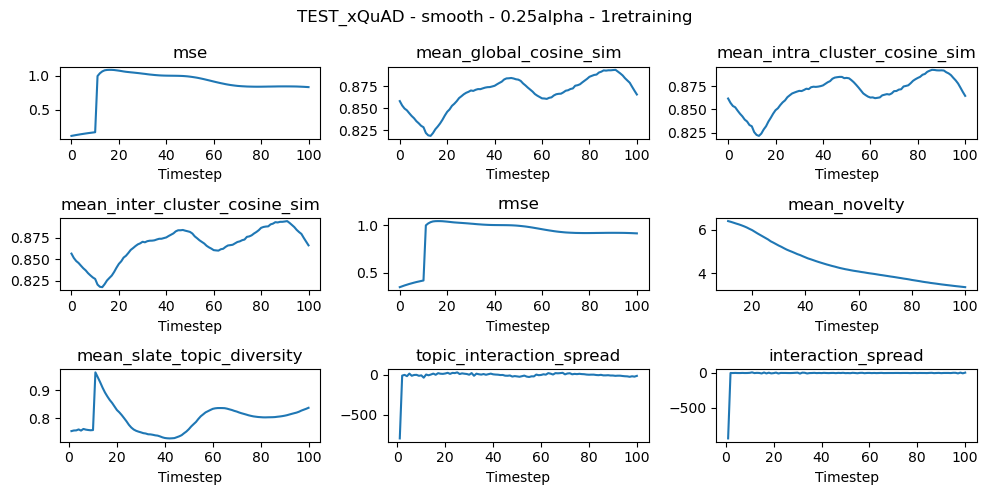

In [33]:
from src.plotting import graph_metrics_by_axis

print(model_params)

fig, axs = plt.subplots(3, 3, figsize=(10, 5))
for i in range(9):
    curr_ax = axs[int(i/3), i%3]
    graph_metrics_by_axis(curr_ax, TEST_measurements, graphing_metrics[i], empty_y_labels)
plt.suptitle(f"TEST_xQuAD - {model_params[0]} - {model_params[1]}alpha - {train_between_steps}retraining")
plt.tight_layout()

('smooth', 0.1)


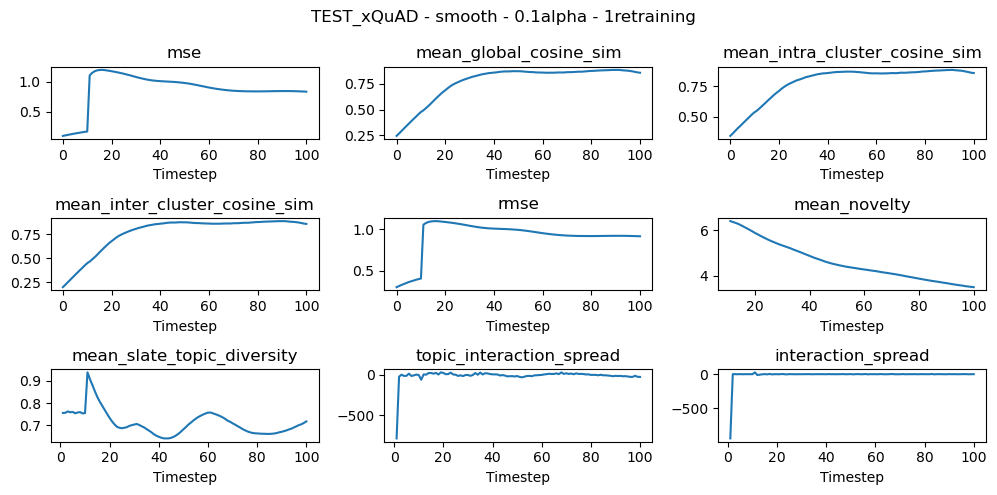

In [31]:
from src.plotting import graph_metrics_by_axis

print(model_params)

fig, axs = plt.subplots(3, 3, figsize=(10, 5))
for i in range(9):
    curr_ax = axs[int(i/3), i%3]
    graph_metrics_by_axis(curr_ax, TEST_measurements, graphing_metrics[i], empty_y_labels)
plt.suptitle(f"TEST_xQuAD - {model_params[0]} - {model_params[1]}alpha - {train_between_steps}retraining")
plt.tight_layout()

('binary', 0.25)


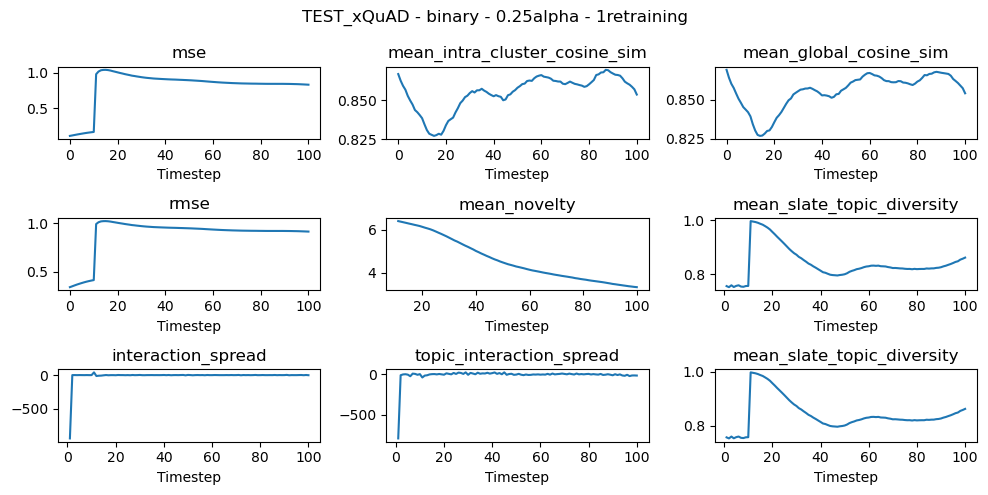

In [23]:
from src.plotting import graph_metrics_by_axis

print(model_params)

fig, axs = plt.subplots(3, 3, figsize=(10, 5))
for i in range(9):
    curr_ax = axs[int(i/3), i%3]
    graph_metrics_by_axis(curr_ax, TEST_measurements, graphing_metrics[i], empty_y_labels)
plt.suptitle(f"TEST_xQuAD - {model_params[0]} - {model_params[1]}alpha - {train_between_steps}retraining")
plt.tight_layout()